In [1]:
##libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.metrics import BinaryCrossentropy, binary_crossentropy
from tensorflow.keras import Input

device= "cuda" if tf.test.is_gpu_available() else "cpu"
print(f"Device: {device}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Device: cuda


In [2]:
## for downloading the dataset from the kaggle
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/hassnainzaidi/ai-art-vs-human-art")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: informatic
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hassnainzaidi/ai-art-vs-human-art


100%|██████████| 476M/476M [00:07<00:00, 70.2MB/s]


In [3]:
##to download the data from kaggle directory
!kaggle datasets download -d hassnainzaidi/ai-art-vs-human-art

Dataset URL: https://www.kaggle.com/datasets/hassnainzaidi/ai-art-vs-human-art
License(s): CC0-1.0
 97% 463M/476M [00:01<00:00, 265MB/s]
100% 476M/476M [00:01<00:00, 328MB/s]


In [4]:
!ls

aiart.jpeg  ai-art-vs-human-art  ai-art-vs-human-art.zip  sample_data


In [5]:
##unzip the data
from zipfile import ZipFile
with ZipFile("ai-art-vs-human-art.zip", "r") as file:
  file.extractall("data")

In [6]:
##project constant
RAW_DIR="data/Art"
IMG_HEIGHT=180
IMG_WIDTH=180
EPOCH=10
BATCH_SIZE=16
SEED=42
CHANNELS=3

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
##loading dataset
raw_data=tf.keras.preprocessing.image_dataset_from_directory(
   RAW_DIR,
   image_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   shuffle=True
)

Found 971 files belonging to 2 classes.


In [9]:
##checking class names
art_class=raw_data.class_names

In [10]:
##number of class
n_class=len(raw_data.class_names)
n_class

2

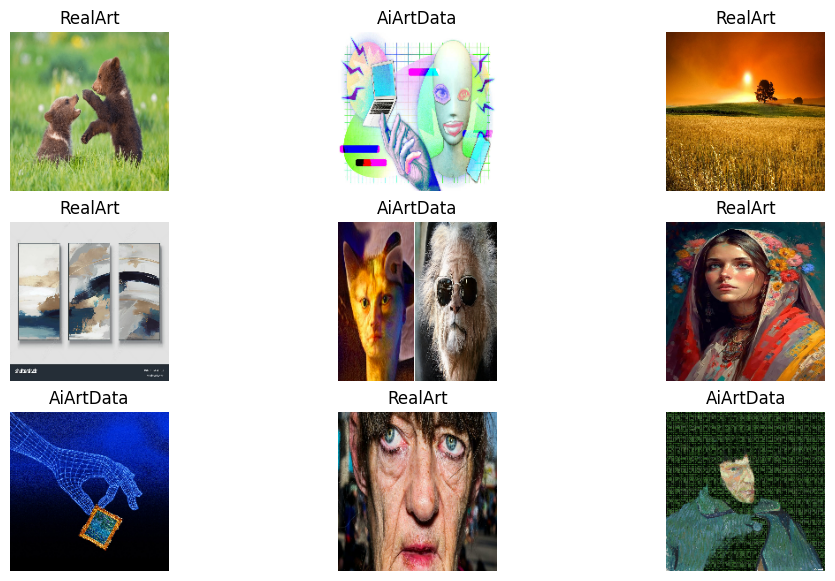

In [11]:
##show image
plt.figure(figsize=(12,7))
for image, label in raw_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(art_class[label[i]])
        plt.axis('off')
plt.show()

In [12]:
##data splitter function
def data_splitter(image_data,
                  train_split_size=0.8,
                  val_split_size=0.1,
                  shuffle=True,
                  shuffle_size=1000):
    if shuffle:
        image_data=image_data.shuffle(shuffle_size, SEED)
    ##total image
    total_img=len(image_data)

    ##total train split images
    train_image_size=int(total_img*train_split_size)
    val_image_size=int(total_img*val_split_size)

    ##images on each split on the raw dataset
    train_ds=image_data.take(train_image_size)
    val_ds=image_data.skip(train_image_size).take(val_image_size)
    test_ds=image_data.skip(train_image_size).skip(val_image_size)

    return train_ds, val_ds, test_ds


In [13]:
##split the data
train, val, test= data_splitter(raw_data)

In [14]:
len(train), len(val), len(test)

(48, 6, 7)

In [15]:
##model
model=Sequential([
    ##input size of the image
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, CHANNELS)),
    ##normalization of the image
    layers.Rescaling(1./255.),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    ##convolution layers
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    ##batch normalization
    layers.BatchNormalization(),
    ##pooling layers
    layers.MaxPool2D(),

    ##2nd convolutional layers
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
    ##maxpooling
    layers.MaxPool2D(),

    ##3rd convolutional layers
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPool2D(),
    ##to reduce overfitting add dropout layers
    layers.Dropout(0.5),

    ##flatten layer to convert the matrix into vector
    layers.Flatten(),
    ##dense hidden layers
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [16]:
##trainable weights/paramters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       903,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,008,033 (3.85 MB)

 Trainable params: 1,007,777 (3.84 MB)

 Non-trainable params: 256 (1.00 KB)

In [17]:
##compile the model with optimizer, loss,
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['BinaryAccuracy'])

In [18]:
##training the model
history=model.fit(train,
          epochs=EPOCH,
          validation_data=val)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - BinaryAccuracy: 0.5119 - loss: 1.0238 - val_BinaryAccuracy: 0.5729 - val_loss: 0.6925
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 416ms/step - BinaryAccuracy: 0.6045 - loss: 0.6675 - val_BinaryAccuracy: 0.6593 - val_loss: 0.6815
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - BinaryAccuracy: 0.5878 - loss: 0.6734 - val_BinaryAccuracy: 0.6562 - val_loss: 0.6810
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - BinaryAccuracy: 0.6365 - loss: 0.6567 - val_BinaryAccuracy: 0.4479 - val_loss: 0.6980
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - BinaryAccuracy: 0.6276 - loss: 0.6617 - val_BinaryAccuracy: 0.3958 - val_loss: 0.7073
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 542ms/step - BinaryAccuracy: 0.6035 - loss: 0.6600 - val_BinaryAccuracy: 0.5604 - val_loss: 0.6667
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - BinaryAccuracy: 0.5933 - loss: 0.6587 - val_BinaryAccuracy: 0.6250 - val_loss: 0.6705
Epoch 8/10
48

In [19]:
##model evaluation
val_loss, val_accuracy = model.evaluate(val)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - BinaryAccuracy: 0.6454 - loss: 0.5728


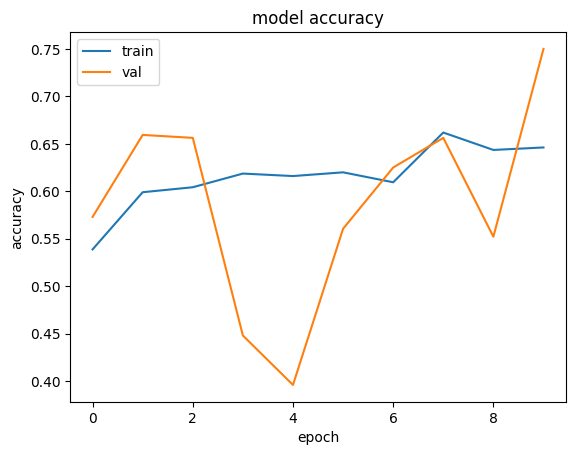

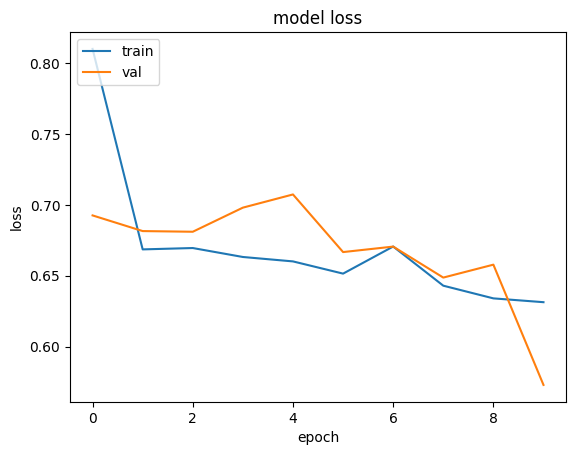

In [20]:
##plotting the validation and train loss and accuracy

plt.plot(history.history['BinaryAccuracy'])
plt.plot(history.history['val_BinaryAccuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
##prediction pipeline
def load_preprocess(image, resize_shape=(180,180)):
  ##open image
  img=Image.open(image)
  ##resize the image
  resize_img=img.resize(resize_shape)
  ##convert it into numpy array
  np_img=np.array(resize_img)
  ##batch dimension
  batch_img=np.expand_dims(np_img, axis=0)
  ##scaling the image so that matrix calculation would be less computationally
  norm_img=batch_img.astype('float32')/255.
  return norm_img

##prediction function
def prediction(model, image, class_name):
  ##load and preprocess
  preprocessed_img=load_preprocess(image)

  ##plot the image
  plt.imshow(np.array(preprocessed_img[0]))
  plt.axis('off')
  ##predict
  pred_image=model.predict(preprocessed_img)
  ##index of class having maximum probabilities value
  pred_index=np.argmax(pred_image, axis=1)[0]
  pred_img_class=class_name[pred_index]
  return pred_img_class


In [22]:
class_indx={k:v for k, v in enumerate(art_class)}
class_indx

{0: 'AiArtData', 1: 'RealArt'}

In [23]:
img_path="/content/aiart.jpeg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'AiArtData'

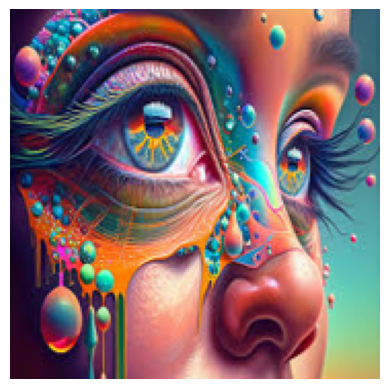

In [26]:
prediction(model,img_path,class_indx)